____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + G (T_e - T_i),
\end{align}
$$

which assumes a cylindrical plasma composed of electrons and ions with no mass flow. 

Main areas where major improvements are needed:
1. Plasma Formulary version of parameters
2. Allow density variation 
3. Nicer visualizations, including animations, would be nice to have in the long run.

Current Bug- Electron Heat Capacity definitely not right!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Create Experimental Information

In [2]:
grid  = Cylindrical_Grid(100e-6, N=100) 
Zstar, A = 54, 131
Te_initial, Ti_initial = 16.60952380952381e3, 3e2 #[K]
laser_width = 25e-6 # [m]
n0 = 1.25e20 *1e6

# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "JT")
ttm_jt = TwoTemperatureModel(Xenon_jt, model = "JT")

Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT")
ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Initial peak T_electron converged:  [21088.68853791] True The solution converged.
Te_max = 2.109e+04 K, Ti_max = 3.809e+02 K
Initial peak T_electron converged:  [21088.68853791] True The solution converged.
Te_max = 2.109e+04 K, Ti_max = 3.809e+02 K


In [3]:
print("JT Model")
ttm_jt.make_times()
ttm_jt.print_timescales()

print("\nSMT Model")
ttm_smt.make_times()
ttm_smt.print_timescales()

JT Model

Simulation time: 4.0e+00 ns,  dt = 3.1e+01 ps, steps = 132
  Diffusion time (r_max): e:3.0e+03 ns, i:2.6e+44 ns 
  Diffusion time (dr): e:3.1e-01 ns, i:2.6e+40 ns 
  Thermalization Times: 8.07e+02 ps  8.07e+02 ps

SMT Model

Simulation time: 6.4e+00 ns,  dt = 1.3e+01 ps, steps = 476
  Diffusion time (r_max): e:1.3e+03 ns, i:2.6e+44 ns 
  Diffusion time (dr): e:1.3e-01 ns, i:2.6e+40 ns 
  Thermalization Times: 1.27e+03 ps  1.27e+03 ps


# Solve Two Temperature Model

In [4]:
ttm_jt.solve_TTM(tmax=18e-9)
ttm_smt.solve_TTM(tmax=18e-9)

# PLOTS

In [5]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title=''):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_list)*0.99,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_list[ti]
        ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
        ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0,50)
    # ax.set_ylim(0,10.1)
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)


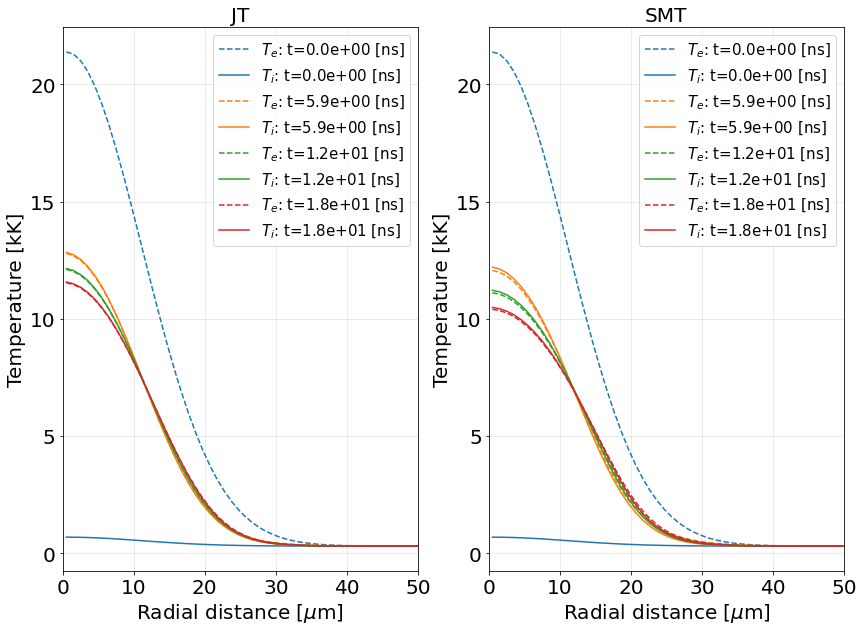

In [6]:
fig, ax = plt.subplots(1,2, figsize=(14,10),facecolor='w')

plot_temp_profiles(ttm_jt, ax = ax[0], title='JT')
plot_temp_profiles(ttm_smt,  ax = ax[1], title='SMT')


In [7]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_data

,t[ns],T[kK]
0,0.000000,16.609524
1,0.059055,16.571429
2,0.118110,16.495238
3,0.206693,16.066667
4,0.295276,15.695238
5,0.531496,15.066667
6,0.767717,14.742857
7,1.033465,14.323810
8,1.624016,13.704762
9,2.066929,13.485714


In [8]:
def plot_bulk_temperature(ttm, exp, plot_times = None, ax = None, title=''):
    bulk_Tes = np.array([exp.get_bulk_T(Te, ttm.n_e) for Te in ttm.Te_list])
    bulk_Tis = np.array([exp.get_bulk_T(Ti, ttm.n_e) for Ti in ttm.Ti_list]) # Use Zstar weighted density? i.e. use ne not ni
    
    T_av = 0.5*(bulk_Tes + bulk_Tis)
    ti_1, ti_2 = -100, -1

    T_av_1 = T_av[ti_1]
    T_av_2 = T_av[ti_2]

    dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])

    T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
    ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
    ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))

    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r--', label='Experiment')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(200, 50), textcoords='offset points',
                va='top', ha='left',fontsize=20,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(80, 40), textcoords='offset points',
                va='top', ha='left',fontsize=20,
                arrowprops=dict(facecolor='black', shrink=0.02))



    # Plot settings
    ax.set_xlabel(r"Time (ns)", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
#     ax.set_ylim(10.8,16.6)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=17)


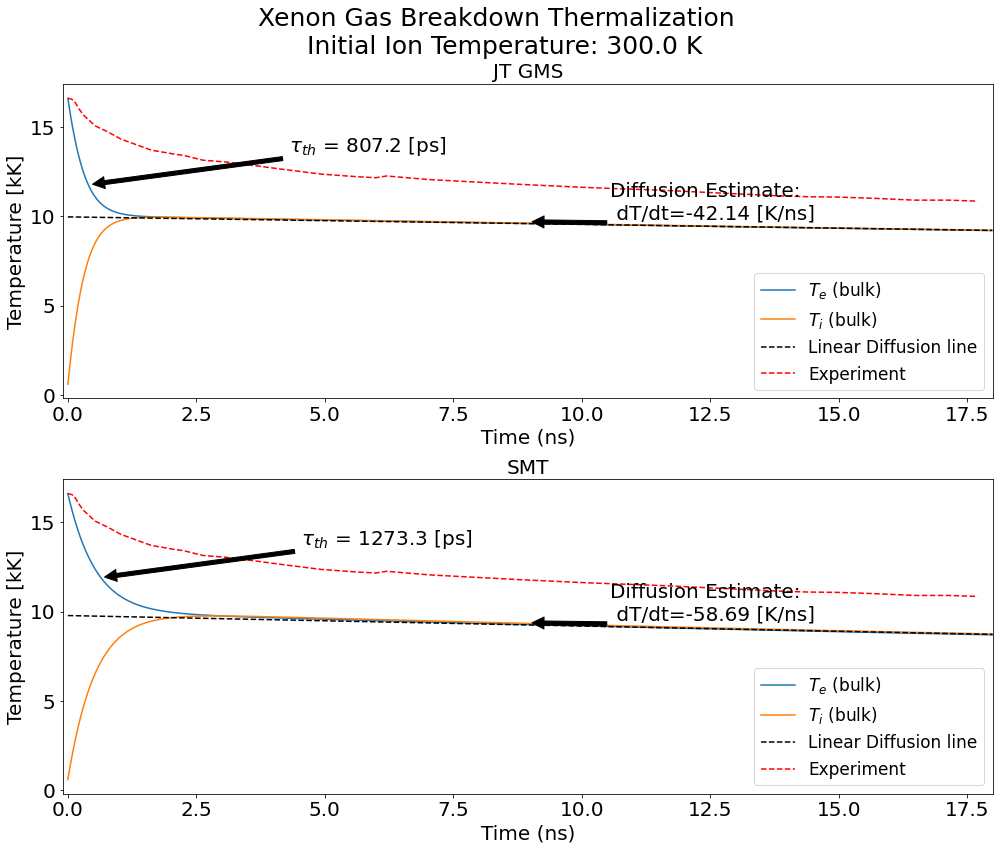

In [10]:
fig, ax = plt.subplots(2,1, figsize=(14,12),facecolor='w')
fig.suptitle('Xenon Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm_jt, Xenon_jt, ax = ax[0], title='JT GMS')
plot_bulk_temperature(ttm_smt, Xenon_smt,  ax = ax[1], title='SMT')
fig.tight_layout()